In [ ]:
import os
path = os.getcwd()
# find the string 'project' in the path, return index
index_project = path.find("project")
# slice the path from the index of 'project' to the end
project_path = path[: index_project + 7]
# set the working directory
os.chdir(project_path + "/src")
print(f"Project path set to: {os.getcwd()}")


Project path set to: c:\Github\new-peak-project\src


In [ ]:
test_model_file = "notebooks/ch5-paper/model-dev/tests/current_model_to_test.txt"
with open(test_model_file, "r") as f:
    model_to_test = f.read().strip()

print(f"Model to test: {model_to_test}")

In [2]:
from models.utils.s3_config_manager import S3ConfigManager

s3_manager = S3ConfigManager()

✅ S3 connection successful. Bucket: bio-data


In [19]:
gen_path = s3_manager.save_result_path 
model_spec = s3_manager.load_data_from_path(f"{gen_path}/models/{model_to_test}/model_spec.pkl", data_format='pkl')
model = s3_manager.load_data_from_path(f"{gen_path}/models/{model_to_test}/model_builder.pkl", data_format='pkl')
tuner = s3_manager.load_data_from_path(f"{gen_path}/models/{model_to_test}/model_tuner.pkl", data_format='pkl')


In [16]:
print(f"Model created: {model.name}")
print(f"Total reactions: {len(model.reactions)}")
print(f"Total states: {len(model.states)}")
print(f"Total parameters: {len(model.parameters)}")


Model created: MultiDegree_Kinetics
Total reactions: 14
Total states: 14
Total parameters: 32


In [17]:
from models.Solver.RoadrunnerSolver import RoadrunnerSolver

# Create solver
solver = RoadrunnerSolver()

# Compile model and simulate
try:
    solver.compile(model.get_sbml_model())
    result = solver.simulate(start=0, stop=10000, step=101)  # 0-1000 with 101 points

    print("Simulation successful!")
    print(f"Timepoints: {len(result['time'])}")
    print(f"Columns: {list(result.columns)[:10]}...")

except Exception as e:
    print(f"Simulation error: {e}")
    # Fallback: try to get antimony model for debugging
    print("\nDebug: Antimony model (first 20 lines):")
    antimony_model = model.get_antimony_model()
    print("\n".join(antimony_model.split("\n")[:20]))

Simulation successful!
Timepoints: 101
Columns: ['time', 'R1_1a', 'R1_1', 'I2_1a', 'I1_1a', 'I1_1', 'I2_2a', 'R2_1a', 'R2_1', 'I2_1']...


In [20]:
target_concentrations = tuner.get_target_concentrations()

In [21]:
# Cross-check if target concentrations were reached at the last timepoint
print("Target Concentration Achievement Analysis")
print("=" * 60)

last_timepoint_pre_drug = result.iloc[-51]  # Get last row of simulation results before drug treatment 
last_timepoint_post_drug = result.iloc[-1]  # Get last row of simulation results after drug treatment

for species, target in target_concentrations.items():
    if species in result.columns:
        final_value = last_timepoint_pre_drug[species]
        difference = final_value - target
        percent_diff = (difference / target) * 100 if target != 0 else 0
        
        status = "✓ Reached" if abs(percent_diff) < 5 else "✗ Not reached"
        
        print(f"{species:8} | Target: {target:8.2f} | Final: {final_value:8.2f} | Diff: {difference:7.2f} ({percent_diff:6.2f}%) | {status}")

Target Concentration Achievement Analysis
R1_1a    | Target:    61.57 | Final:    61.91 | Diff:    0.34 (  0.56%) | ✓ Reached
I1_1a    | Target:    29.48 | Final:    29.45 | Diff:   -0.03 ( -0.11%) | ✓ Reached
R2_1a    | Target:    63.70 | Final:    64.98 | Diff:    1.28 (  2.01%) | ✓ Reached
I2_1a    | Target:    31.26 | Final:    31.86 | Diff:    0.60 (  1.91%) | ✓ Reached
R2_2a    | Target:    45.25 | Final:    43.31 | Diff:   -1.94 ( -4.28%) | ✓ Reached
I2_2a    | Target:    60.74 | Final:    61.26 | Diff:    0.52 (  0.85%) | ✓ Reached
Oa       | Target:    34.45 | Final:    35.00 | Diff:    0.55 (  1.59%) | ✓ Reached


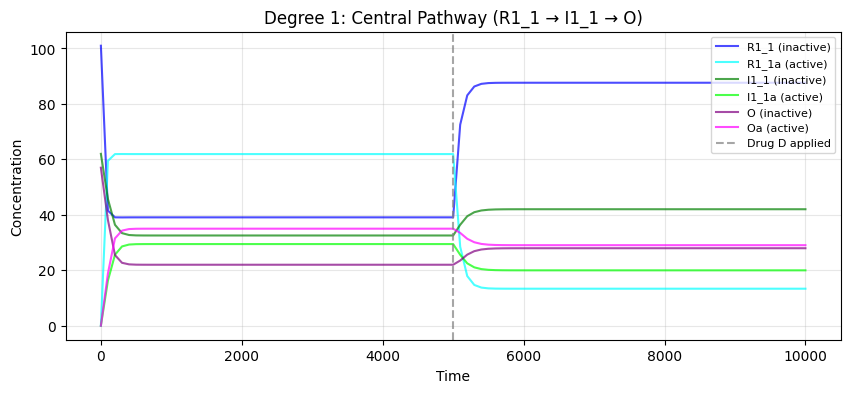

In [26]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10, 4))

# Subplot 1: Degree 1 (central pathway)
plt.plot(result['time'], result['R1_1'], label='R1_1 (inactive)', color='blue', alpha=0.7)
plt.plot(result['time'], result['R1_1a'], label='R1_1a (active)', color='cyan', alpha=0.7)
plt.plot(result['time'], result['I1_1'], label='I1_1 (inactive)', color='green', alpha=0.7)
plt.plot(result['time'], result['I1_1a'], label='I1_1a (active)', color='lime', alpha=0.7)
plt.plot(result['time'], result['O'], label='O (inactive)', color='purple', alpha=0.7)
plt.plot(result['time'], result['Oa'], label='Oa (active)', color='magenta', alpha=0.7)
plt.axvline(x=5000, color='gray', linestyle='--', alpha=0.7, label='Drug D applied')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Degree 1: Central Pathway (R1_1 → I1_1 → O)')
plt.legend(loc='upper right', fontsize=8)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Test making data

from models.utils.data_generation_helpers import make_data_extended
import time

state_variables = model.get_state_variables()

# get state variables that end with 'a' (active forms)
active_state_variables = {k: v for k, v in state_variables.items() if k.endswith("a")}

# filter out all active state variables
inactive_state_variables = {
    k: v for k, v in state_variables.items() if not k.endswith("a")
}
# further filter out 'O' if present
if "O" in inactive_state_variables:
    del inactive_state_variables["O"]
    
kinetic_parameters = model.get_parameters()

start_time = time.perf_counter()
results = make_data_extended(
    initial_values=inactive_state_variables,
    perturbation_type="lognormal",
    perturbation_params={"shape": 0.5},
    parameter_values=kinetic_parameters,
    param_perturbation_type="lognormal",
    param_perturbation_params={"shape": 0.5},
    n_samples=10,
    model_spec=model_spec,
    solver=solver,
    simulation_params={"start": 0, "end": 10000, "points": 101},
    seed=42,
    outcome_var="Oa",
    capture_all_species=True,
)
elapsed = time.perf_counter() - start_time
time_per_sample = elapsed / results["metadata"]["n_samples"]
print(f"Time per sample: {time_per_sample:.4f}s (total {elapsed:.2f}s)")

# Estimate time for larger sample sizes
estimated_100 = time_per_sample * 100
estimated_1000 = time_per_sample * 1000
print(f"Estimated time for 100 samples:  {estimated_100:.2f}s")
print(f"Estimated time for 1000 samples: {estimated_1000:.2f}s")


Time per sample: 0.0035s (total 0.03s)
Estimated time for 100 samples:  0.35s
Estimated time for 1000 samples: 3.50s
